<a href="https://colab.research.google.com/github/Rohith-Rongali/IMP/blob/main/IMP_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune

from copy import deepcopy

from tqdm import tqdm
import os

import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace

# Data functions

In [2]:
def generate_points(num=40000,dim=18,type='normal',normal_var=1,radius=1):
    '''
    If type=='normal', then generate points from N(0,normal_var)
    If type=='spherical', then simply divide the points by their norm.'''
    X = torch.randn([num,dim]) #coordinates sampled from N(0,1)

    if type=='spherical':
      norm = torch.norm(X, p=2, dim=1, keepdim=True)
      X_spherical = X / norm
      return X_spherical

    elif type=='normal':
      return X

    else:
      raise ValueError('type should be either normal or spherical')


class TreeNode:
    '''
    This class represents a node in the decision tree.
    Each node has a depth, a maximum depth(of the tree), a feature index, and left and right child nodes.
    Leaf nodes have a value, which is the predicted class.
    '''
    def __init__(self, depth, max_depth, feature_index):
        self.depth = depth
        self.max_depth = max_depth
        self.feature = feature_index
        self.left = None
        self.right = None
        self.value = None  # This will store the predicted class for leaf nodes

    def build_tree(self):
        if self.depth == self.max_depth:
            self.value = float(self.feature % 2)
            return

        # Create left and right child nodes
        self.left = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+1)
        self.right = TreeNode(self.depth + 1, self.max_depth, 2*self.feature+2)

        # Recursively build left and right subtrees
        self.left.build_tree()
        self.right.build_tree()

    def predict(self, x):
        if self.value is not None:
            return self.value

        if x[self.feature] > 0:
            return self.left.predict(x)
        else:
            return self.right.predict(x)


def gen_std_basis_DT(depth, dim_in, type_data, num_points, feat_index_start=0,radius=1):
    '''
    Generate points uniformly random from a hypersphere. And the label is the prediction of the tree with depth = max_depth.
    The node hyperplanes are simply characterised by standard basis vectors(for example, the root node hyperplane is x[0] = 0)

    '''
    Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
    Tree.build_tree()
    X = generate_points(num=num_points,dim=dim_in,type=type_data,radius=radius)

    Y=[]
    for item in X:
        Y.append(Tree.predict(item))

    Y = torch.tensor(Y)
    return X,Y




def set_npseed(seed):
	np.random.seed(seed)


def set_torchseed(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False



# depth = 4
# dim_in = 18
# type_data = 'normal'
# feat_index_start = 0 #the index of the first feature in the tree
# num_points = 40000


#     Tree = TreeNode(depth = 0,max_depth=depth,feature_index = feat_index_start)
#     Tree.build_tree()
#     X = generate_points(num=num_points,dim=dim_in,type=type_data)

#     Y=[]
#     for item in X:
#     Y.append(Tree.predict(item))

#     Y = torch.tensor(Y)

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample_x = self.x[idx]
        sample_y = self.y[idx]

        if self.transform:
            sample_x, sample_y = self.transform(sample_x, sample_y)

        return sample_x, sample_y

def return_data_elements(DataConfig):
    # returns [data] and data_loader

    x_train,y_train = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    x_test,y_test = gen_std_basis_DT(depth = DataConfig.depth, dim_in = DataConfig.dim_in, num_points = DataConfig.num_points,type_data= DataConfig.type_data, radius = DataConfig.radius)
    # x_train, x_test, y_train, y_test = train_test_split(
    # X, Y, test_size=0.1, random_state=42, stratify=Y)

    data = [x_train,y_train.long(),x_test,y_test.long()]

    return data

def loaders(data,batch_size=32):
    x_train,y_train,x_test,y_test = data
    train_dataset = CustomDataset(x_train, y_train)
    test_dataset = CustomDataset(x_test, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

# Models


In [3]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, width, depth):
        super(DNN, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList([nn.Linear(dim_in if i == 0 else width, width) for i in range(self.depth)])
        self.output_layer = nn.Linear(width, dim_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

# Configs

In [24]:

model_config = SimpleNamespace(
    width=256,
    depth=2
)

data_config = SimpleNamespace(
    dim_in=100,
    depth=4,
    type_data='spherical',
    num_points=30000,
    radius=1,
    dim_out=2
)

train_config = SimpleNamespace(
    batch_size=32,
    lr=0.01,
    epochs=100
)


# Training

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
data= return_data_elements(data_config)
x_train,y_train,x_test,y_test = data

In [27]:
# Create DataLoaders for train and test datasets
batch_size = 32

# Assuming you have a custom Dataset class, you can create instances like this:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
model = DNN(dim_in=data_config.dim_in, dim_out=data_config.dim_out, width=model_config.width, depth=model_config.depth)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=train_config.lr)

In [29]:
def train(model,loss_fn,optimizer,train_dataloader,
          data,num_epochs=train_config.epochs,log_epochs=10,log_acc=10,thresh=1e-5,print_std=True):
  [x_train,y_train,x_test,y_test]=data
  model.to(device)
  Train_losses=[]
  acc_dict = {'train':[],'test':[]}
  for epoch in range(num_epochs):
      model.train()
      for x_batch, y_batch in train_dataloader:
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()


      if epoch % log_epochs == 0:
          loss_full = loss_fn(model(x_train.to(device)),y_train.to(device))
          Train_losses.append(loss_full.item())
          print(f'Epoch {epoch} Loss {loss_full.item():.4f}')
      if log_acc!=0:
        if epoch % log_acc == 0:
          train_pred = model(x_train.to(device))
          pred = torch.argmax(model(x_train.to(device)),dim=1)
          zero_mask = (pred-y_train.to(device) == 0.0)
          train_acc = zero_mask.sum().item()/len(y_train)
          acc_dict['train'].append(train_acc)

          test_pred = model(x_test.to(device))[:,0]
          pred = torch.argmax(model(x_test.to(device)),dim=1)
          zero_mask = (pred-y_test.to(device) == 0.0)
          test_acc = zero_mask.sum().item()/len(y_test)
          acc_dict['test'].append(test_acc)

          if print_std:
            print(f'Epoch {epoch} train_acc {train_acc} test_acc {test_acc}')
      if loss_full.item() < thresh:
          print(f'Early stopping at epoch {epoch} because loss is below 0.01')
          break

  return Train_losses,acc_dict

In [30]:
losses, acc_dict = train(model,loss_fn,optimizer,train_dataloader,data)

Epoch 0 Loss 0.6169
Epoch 0 train_acc 0.6572333333333333 test_acc 0.6300333333333333
Epoch 10 Loss 0.1693
Epoch 10 train_acc 0.9347333333333333 test_acc 0.6691333333333334
Epoch 20 Loss 0.0688
Epoch 20 train_acc 0.9766 test_acc 0.6722
Epoch 30 Loss 0.0505
Epoch 30 train_acc 0.9832666666666666 test_acc 0.6690666666666667
Epoch 40 Loss 0.0503
Epoch 40 train_acc 0.9836 test_acc 0.6641666666666667
Epoch 50 Loss 0.0442
Epoch 50 train_acc 0.9867 test_acc 0.6748666666666666
Epoch 60 Loss 0.0320
Epoch 60 train_acc 0.9907 test_acc 0.6687666666666666
Epoch 70 Loss 0.0259
Epoch 70 train_acc 0.992 test_acc 0.6707
Epoch 80 Loss 0.0292
Epoch 80 train_acc 0.9916 test_acc 0.6694
Epoch 90 Loss 0.0230
Epoch 90 train_acc 0.9936666666666667 test_acc 0.6694333333333333


## Pruning

So far everything is the same. I set the pruning rate as $p ^ {1/n}$, this still works to some extent... Not sure how? I think we should still figure out some other schemes, maybe we can threshold the weights instead of removing a certain amount of smaller magnitude weights....

In [31]:
INITIAL_WEIGHTS = deepcopy(model.state_dict())
prune_epochs=6
p = 0.2
losses = {}
acc_dict = {}
for n in tqdm(range(1, prune_epochs + 1), total=prune_epochs, leave=False):

  losses[n], acc_dict[n] = train(model,loss_fn,optimizer,train_dataloader,data)

  pruning_rate = p ** (1 / n)

  # Prune the model
  prune.l1_unstructured(model.layers[0], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.layers[1], name="weight", amount=pruning_rate)
  prune.l1_unstructured(model.output_layer, name="weight", amount=pruning_rate/2)

  # Reset weights
  reseted_weights = deepcopy(model.state_dict())
  for param in reseted_weights.keys():
      if param.split(".")[-1].replace("_orig", "") in ("bias", "weight"):
          reseted_weights[param] = deepcopy(INITIAL_WEIGHTS[param.replace("_orig", "")])
  if n< prune_epochs-1:
    model.load_state_dict(reseted_weights)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0 Loss 0.0317
Epoch 0 train_acc 0.9905 test_acc 0.6689666666666667
Epoch 10 Loss 0.0274
Epoch 10 train_acc 0.9934333333333333 test_acc 0.6716666666666666
Epoch 20 Loss 0.0223
Epoch 20 train_acc 0.9944 test_acc 0.6708
Epoch 30 Loss 0.0472
Epoch 30 train_acc 0.9899333333333333 test_acc 0.6679
Epoch 40 Loss 0.0586
Epoch 40 train_acc 0.9894 test_acc 0.6704666666666667
Epoch 50 Loss 0.0457
Epoch 50 train_acc 0.9905666666666667 test_acc 0.6718666666666666
Epoch 60 Loss 0.0201
Epoch 60 train_acc 0.9957 test_acc 0.6686333333333333
Epoch 70 Loss 0.0439
Epoch 70 train_acc 0.9923666666666666 test_acc 0.6739
Epoch 80 Loss 0.0254
Epoch 80 train_acc 0.9942 test_acc 0.6658333333333334
Epoch 90 Loss 0.0331
Epoch 90 train_acc 0.9932 test_acc 0.6697666666666666


 17%|█▋        | 1/6 [01:41<08:26, 101.31s/it]

Epoch 0 Loss 0.0363
Epoch 0 train_acc 0.9894 test_acc 0.6728
Epoch 10 Loss 0.0201
Epoch 10 train_acc 0.9948333333333333 test_acc 0.6746
Epoch 20 Loss 0.0154
Epoch 20 train_acc 0.9957333333333334 test_acc 0.6713333333333333
Epoch 30 Loss 0.0249
Epoch 30 train_acc 0.9937333333333334 test_acc 0.6696333333333333
Epoch 40 Loss 0.0378
Epoch 40 train_acc 0.9915666666666667 test_acc 0.6685333333333333
Epoch 50 Loss 0.0289
Epoch 50 train_acc 0.9936 test_acc 0.6729
Epoch 60 Loss 0.0299
Epoch 60 train_acc 0.9939 test_acc 0.6686
Epoch 70 Loss 0.0374
Epoch 70 train_acc 0.9939 test_acc 0.6757666666666666
Epoch 80 Loss 0.0153
Epoch 80 train_acc 0.9958666666666667 test_acc 0.6752
Epoch 90 Loss 0.0519
Epoch 90 train_acc 0.9874333333333334 test_acc 0.6736333333333333


 33%|███▎      | 2/6 [03:36<07:17, 109.28s/it]

Epoch 0 Loss 0.1614
Epoch 0 train_acc 0.9409666666666666 test_acc 0.6797666666666666
Epoch 10 Loss 0.0419
Epoch 10 train_acc 0.9881 test_acc 0.6813
Epoch 20 Loss 0.0323
Epoch 20 train_acc 0.9914333333333334 test_acc 0.6815333333333333
Epoch 30 Loss 0.0312
Epoch 30 train_acc 0.9921333333333333 test_acc 0.6814666666666667
Epoch 40 Loss 0.0354
Epoch 40 train_acc 0.9896333333333334 test_acc 0.6829666666666667
Epoch 50 Loss 0.0310
Epoch 50 train_acc 0.9926 test_acc 0.6814
Epoch 60 Loss 0.0217
Epoch 60 train_acc 0.9949666666666667 test_acc 0.6839333333333333
Epoch 70 Loss 0.0153
Epoch 70 train_acc 0.9960666666666667 test_acc 0.6830666666666667
Epoch 80 Loss 0.0238
Epoch 80 train_acc 0.9940666666666667 test_acc 0.6815
Epoch 90 Loss 0.0257
Epoch 90 train_acc 0.9946 test_acc 0.6821


 50%|█████     | 3/6 [05:31<05:36, 112.00s/it]

Epoch 0 Loss 0.4272
Epoch 0 train_acc 0.8043333333333333 test_acc 0.7145666666666667
Epoch 10 Loss 0.2140
Epoch 10 train_acc 0.9134 test_acc 0.7413666666666666
Epoch 20 Loss 0.1630
Epoch 20 train_acc 0.9336666666666666 test_acc 0.7409666666666667
Epoch 30 Loss 0.1426
Epoch 30 train_acc 0.9458333333333333 test_acc 0.7374
Epoch 40 Loss 0.1218
Epoch 40 train_acc 0.9531 test_acc 0.7401
Epoch 50 Loss 0.1151
Epoch 50 train_acc 0.9568 test_acc 0.7404333333333334
Epoch 60 Loss 0.1022
Epoch 60 train_acc 0.9624 test_acc 0.7402333333333333
Epoch 70 Loss 0.0988
Epoch 70 train_acc 0.9650333333333333 test_acc 0.7396333333333334
Epoch 80 Loss 0.0807
Epoch 80 train_acc 0.9697333333333333 test_acc 0.74
Epoch 90 Loss 0.0848
Epoch 90 train_acc 0.9702666666666667 test_acc 0.7395333333333334


 67%|██████▋   | 4/6 [07:27<03:47, 113.62s/it]

Epoch 0 Loss 0.5305
Epoch 0 train_acc 0.7259 test_acc 0.7131666666666666
Epoch 10 Loss 0.3117
Epoch 10 train_acc 0.8689333333333333 test_acc 0.8475666666666667
Epoch 20 Loss 0.2382
Epoch 20 train_acc 0.9041666666666667 test_acc 0.8706
Epoch 30 Loss 0.1871
Epoch 30 train_acc 0.9257333333333333 test_acc 0.8907333333333334
Epoch 40 Loss 0.1447
Epoch 40 train_acc 0.9443666666666667 test_acc 0.9113
Epoch 50 Loss 0.1246
Epoch 50 train_acc 0.9543666666666667 test_acc 0.9234
Epoch 60 Loss 0.1008
Epoch 60 train_acc 0.9643333333333334 test_acc 0.9318666666666666
Epoch 70 Loss 0.0816
Epoch 70 train_acc 0.9714666666666667 test_acc 0.9397
Epoch 80 Loss 0.0691
Epoch 80 train_acc 0.9749333333333333 test_acc 0.9430666666666667
Epoch 90 Loss 0.0637
Epoch 90 train_acc 0.9785 test_acc 0.9500333333333333


 83%|████████▎ | 5/6 [09:26<01:55, 115.44s/it]

Epoch 0 Loss 0.4828
Epoch 0 train_acc 0.7332 test_acc 0.7367666666666667
Epoch 10 Loss 0.4252
Epoch 10 train_acc 0.7524333333333333 test_acc 0.7541333333333333
Epoch 20 Loss 0.4224
Epoch 20 train_acc 0.7552 test_acc 0.7574333333333333
Epoch 30 Loss 0.4224
Epoch 30 train_acc 0.7554666666666666 test_acc 0.7569333333333333
Epoch 40 Loss 0.3735
Epoch 40 train_acc 0.8285333333333333 test_acc 0.8235
Epoch 50 Loss 0.3369
Epoch 50 train_acc 0.8443666666666667 test_acc 0.8412333333333334
Epoch 60 Loss 0.3409
Epoch 60 train_acc 0.8447666666666667 test_acc 0.8429333333333333
Epoch 70 Loss 0.3371
Epoch 70 train_acc 0.8462333333333333 test_acc 0.8436666666666667
Epoch 80 Loss 0.3386
Epoch 80 train_acc 0.8477333333333333 test_acc 0.8477333333333333
Epoch 90 Loss 0.3414
Epoch 90 train_acc 0.8447 test_acc 0.8432


## Probing

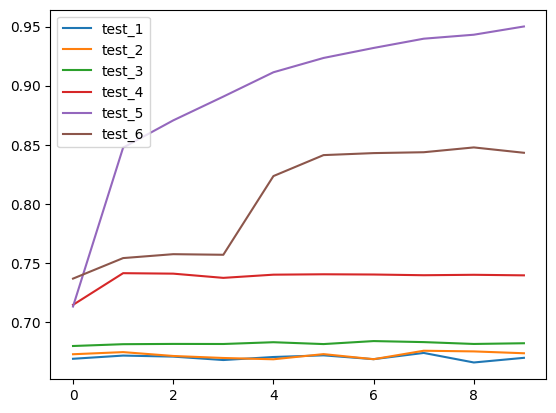

In [34]:
#plot acc_dict(test)
plt.figure()
for key in acc_dict.keys():
#   plt.plot(acc_dict[key]['train'],label=f'train_{key}')
  plt.plot(acc_dict[key]['test'],label=f'test_{key}')
plt.legend()

The test accuracy is definitely improving with pruning, only till a certain point after which I guess we remove too many weights because of the current pruning rate heuristic and hence there is a drop in test accuracy.

Text(0, 0.5, 'Final accuracy')

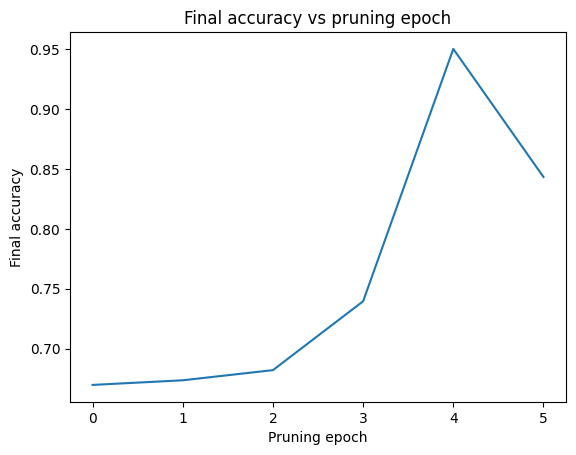

In [37]:
final_acc_list = [acc_dict[key]['test'][-1] for key in acc_dict.keys()]
plt.figure()
plt.plot(final_acc_list)
plt.title('Final accuracy vs pruning epoch')
plt.xlabel('Pruning epoch')
plt.ylabel('Final accuracy')

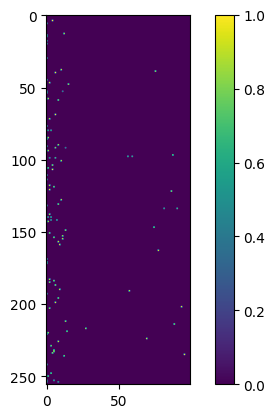

In [38]:
#normalise weights1 row-wise
wt_mat = model.layers[0].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()

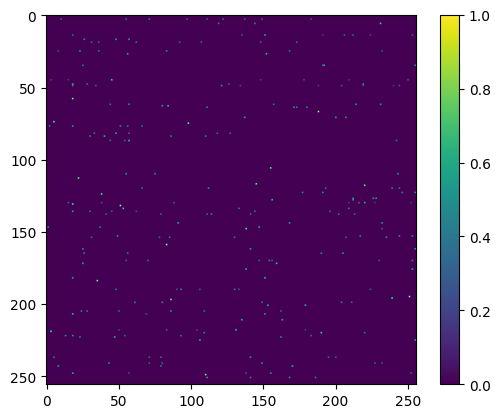

In [39]:
#normalise weights1 row-wise
wt_mat = model.layers[1].weight.data.detach().cpu()
w1_normed=F.normalize(wt_mat,p=2,dim=1)
#visualise w1_normed as heat-map just in absolute values
plt.imshow(w1_normed.abs().numpy())
plt.colorbar()
plt.show()